In [79]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    LeaveOneOut,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay)

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

RANDOM_STATE = 42

## Предобработка изначального датасета

Изначальный датасет очень большой и содержит много ненужного, поэтому он был очищен и сохранён в изменённом виде. Код в этом разделе не запустится, так как изначальный датасет был удалён.

In [3]:
# asteroid = pd.read_csv("./Asteroid_Updated.csv")

In [4]:
# asteroid

In [5]:
# asteroid.info()

In [6]:
# asteroid.columns

In [7]:
# asteroid.groupby("class").agg("count")

In [8]:
# asteroid_filtered = asteroid[asteroid["class"].isin(("AMO", "APO", "ATE", "IMB", "MBA", "MCA", "OMB", "TJN", "TNO"))]
# asteroid_filtered = asteroid_filtered[['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'condition_code', 'n_obs_used', 'H', 'neo', 'pha', 'diameter', 'albedo', 'rot_per', 'moid', 'class', 'n', 'per', 'ma']]
# asteroid_filtered_MBA = asteroid_filtered[asteroid_filtered["class"] == "MBA"]
# asteroid_filtered = pd.concat((asteroid_filtered[asteroid_filtered["class"] != "MBA"], asteroid_filtered_MBA.loc[np.random.choice(asteroid_filtered_MBA.index, 30000, replace=False)]))
# asteroid_filtered.groupby("class").agg("count")

In [9]:
# asteroid_filtered.to_csv("./Asteroid.csv", index=False)

## Изучаем и обрабатываем данные

Данные взяты с сайта Kaggle: https://www.kaggle.com/datasets/basu369victor/prediction-of-asteroid-diameter?select=Asteroid_Updated.csv

Это датасет астероидов, где представлены их характеристики и класс.

Расшифровка столбцов:

- name - имя;

- a - большая полуось (астрономические единицы);

- e - эксцентриситет;

- i - угол наклона орбиты к эклиптике (градусы);

- om - долгота восходящего узла в градусах;

- w - аргумент перигелия в градусах;

- q - перигелий (астрономические единицы);

- ad - апогелий (астрономические единицы);

- per_y - синодический период в годах;

- data_arc - количество дней наблюдения;

- condition code - оценка неопределённости орбиты (0 - хорошо определена, 9 - неопределена);

- n_obs_used - количество наблюдений;

- H - абсолютная звёздная величина;

- diameter - диаметр в км;

- extent - три (или два) осевых диаметра в км;

- albedo - альбедо;

- rot_per - период обращения вокруг оси в часах;

- GM - стандартный гравитационный параметр;

- BV - индекс цвета B-V величины;

- UB - индекс цвета U-B величины;

- spec_B - Спектральный тип SMASSII;

- spec_T - Спектральный тип Толена;

- G - параметр наклона;

- moid - минимальная дистанция до Земли в астрономических единицах;

- class - классификация (AMO - околоземные (Амур), APO - околоземные (Аполон), AST - астероид, ATE - околоземные (Атон), CEN - центавры, IMB - внутренний пояс астероидов, MBA - основной пояс астеороидов, MCA - пересекающие орбиту Марса, OMB - внешний пояс астероидов, TJN - троянские, TNO - транс-нептуновые объекты);

- n - средняя скорость (градусы в день);

- per - сидерический период в днях.

In [2]:
asteroid = pd.read_csv("Asteroid.csv")
asteroid = asteroid.drop("condition_code", axis=1)
asteroid

/tmp/ipykernel_8938/1876347998.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  asteroid = pd.read_csv("Asteroid.csv")


,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,...,neo,pha,diameter,albedo,rot_per,moid,class,n,per,ma
0,3.425953,0.111943,3.563531,155.616309,102.630757,3.042442,3.809464,6.341329,57769.0,3172,...,N,N,237.260,0.0706,6.0814,2.029720,OMB,0.155429,2316.170374,261.006981
1,3.412680,0.165829,2.121740,204.303878,252.403784,2.846760,3.978601,6.304514,56820.0,3207,...,N,N,145.423,0.0580,9.9730,1.864610,OMB,0.156337,2302.723910,284.118282
2,3.482566,0.093063,10.877106,73.045343,263.557968,3.158467,3.806665,6.499161,45653.0,3506,...,N,N,253.051,0.0460,5.1840,2.173690,OMB,0.151654,2373.818434,92.817112
3,3.491539,0.065377,9.999895,172.596805,306.594357,3.263273,3.719805,6.524293,55116.0,3127,...,N,N,254.000,0.0590,4.8440,2.291580,OMB,0.151070,2382.998057,326.496476
4,3.236576,0.055475,4.220482,349.986067,205.565027,3.057027,3.416126,5.822868,50873.0,2652,...,N,N,75.498,0.1480,14.2560,2.056780,OMB,0.169268,2126.802656,334.863327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121691,2.550300,0.063148,15.729461,53.122814,67.372412,2.389254,2.711346,4.072819,1469.0,27,...,N,N,NaN,NaN,NaN,1.447190,MBA,0.242001,1487.597227,222.834541
121692,2.855139,0.066580,2.283566,166.624861,241.160083,2.665044,3.045233,4.824464,5551.0,97,...,N,N,NaN,NaN,NaN,1.675020,MBA,0.204298,1762.135317,144.105461
121693,2.926821,0.132271,0.905181,277.734448,116.078785,2.539687,3.313956,5.007288,6321.0,111,...,N,N,NaN,NaN,NaN,1.545530,MBA,0.196838,1828.911855,332.062973
121694,2.693184,0.297831,2.751445,188.180732,200.992966,1.891070,3.495298,4.419847,6671.0,106,...,N,N,NaN,NaN,NaN,0.895818,MBA,0.223000,1614.349162,225.440049


### Какие есть столбцы признаков

In [9]:
y_column = "class"
X_column = [c for c in asteroid.columns if c != y_column]
print(X_column)

['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'n_obs_used', 'H', 'neo', 'pha', 'diameter', 'albedo', 'rot_per', 'moid', 'n', 'per', 'ma']


### Кодируем признаки (YES/NO -> 1/0)

In [10]:
X, y = asteroid[X_column], asteroid[y_column]
pd.set_option("future.no_silent_downcasting", True)
X["neo"] = X["neo"].replace({"N": 0, "Y": 1}).astype("int")
X["pha"] = X["pha"].replace({"N": 0, "Y": 1}).astype("float64")
X.head()

/tmp/ipykernel_8938/2229386203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["neo"] = X["neo"].replace({"N": 0, "Y": 1}).astype("int")
/tmp/ipykernel_8938/2229386203.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["pha"] = X["pha"].replace({"N": 0, "Y": 1}).astype("float64")


,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,H,neo,pha,diameter,albedo,rot_per,moid,n,per,ma
0,3.425953,0.111943,3.563531,155.616309,102.630757,3.042442,3.809464,6.341329,57769.0,3172,6.62,0,0.0,237.260,0.0706,6.0814,2.02972,0.155429,2316.170374,261.006981
1,3.412680,0.165829,2.121740,204.303878,252.403784,2.846760,3.978601,6.304514,56820.0,3207,7.90,0,0.0,145.423,0.0580,9.9730,1.86461,0.156337,2302.723910,284.118282
2,3.482566,0.093063,10.877106,73.045343,263.557968,3.158467,3.806665,6.499161,45653.0,3506,6.94,0,0.0,253.051,0.0460,5.1840,2.17369,0.151654,2373.818434,92.817112
3,3.491539,0.065377,9.999895,172.596805,306.594357,3.263273,3.719805,6.524293,55116.0,3127,7.08,0,0.0,254.000,0.0590,4.8440,2.29158,0.151070,2382.998057,326.496476
4,3.236576,0.055475,4.220482,349.986067,205.565027,3.057027,3.416126,5.822868,50873.0,2652,8.09,0,0.0,75.498,0.1480,14.2560,2.05678,0.169268,2126.802656,334.863327


### Какие есть классы

In [19]:
label_to_int = {name: i for i, name in enumerate(y.unique())}
target_names = list(label_to_int.keys())
label_to_int

{'OMB': 0,
 'MCA': 1,
 'AMO': 2,
 'IMB': 3,
 'TJN': 4,
 'APO': 5,
 'ATE': 6,
 'TNO': 7,
 'MBA': 8}

### Общая информация о столбцах

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121696 entries, 0 to 121695
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   a           121696 non-null  float64
 1   e           121696 non-null  float64
 2   i           121696 non-null  float64
 3   om          121696 non-null  float64
 4   w           121696 non-null  float64
 5   q           121696 non-null  float64
 6   ad          121696 non-null  float64
 7   per_y       121696 non-null  float64
 8   data_arc    120079 non-null  float64
 9   n_obs_used  121696 non-null  int64  
 10  H           120676 non-null  float64
 11  neo         121696 non-null  int64  
 12  pha         120057 non-null  float64
 13  diameter    16235 non-null   float64
 14  albedo      16045 non-null   float64
 15  rot_per     3799 non-null    float64
 16  moid        120057 non-null  float64
 17  n           121696 non-null  float64
 18  per         121696 non-null  float64
 19  ma

### Соотношение численности классов

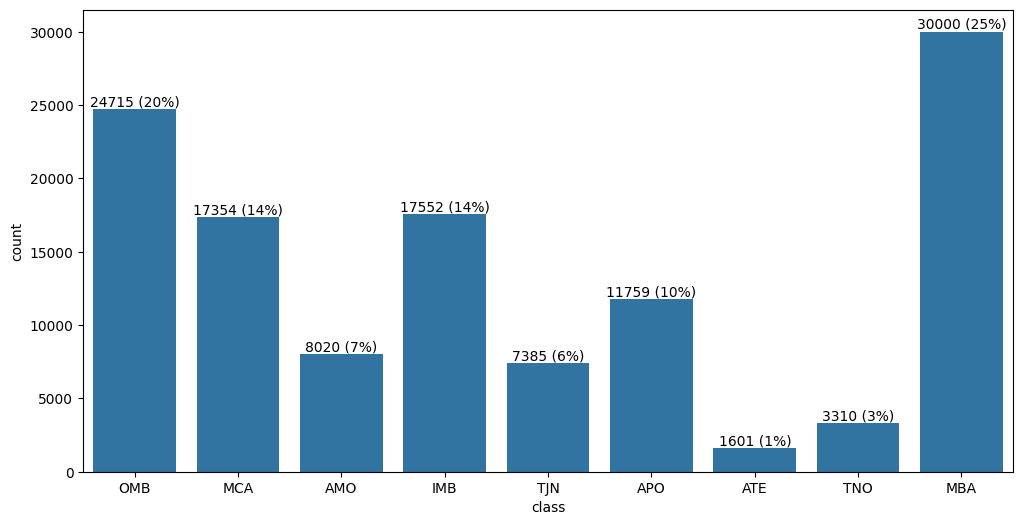

In [8]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=y)

abs_values = y.value_counts(sort=False, ascending=False)
rel_values = y.value_counts(sort=False, ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)
plt.show()

### Кодируем классы числами

In [13]:
y_int = y.replace(label_to_int).astype("int")
y_int.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

### Делим на трейн и тест

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_int, test_size=0.20, stratify=y_int, random_state=RANDOM_STATE
)

## Обучим решающее дерево

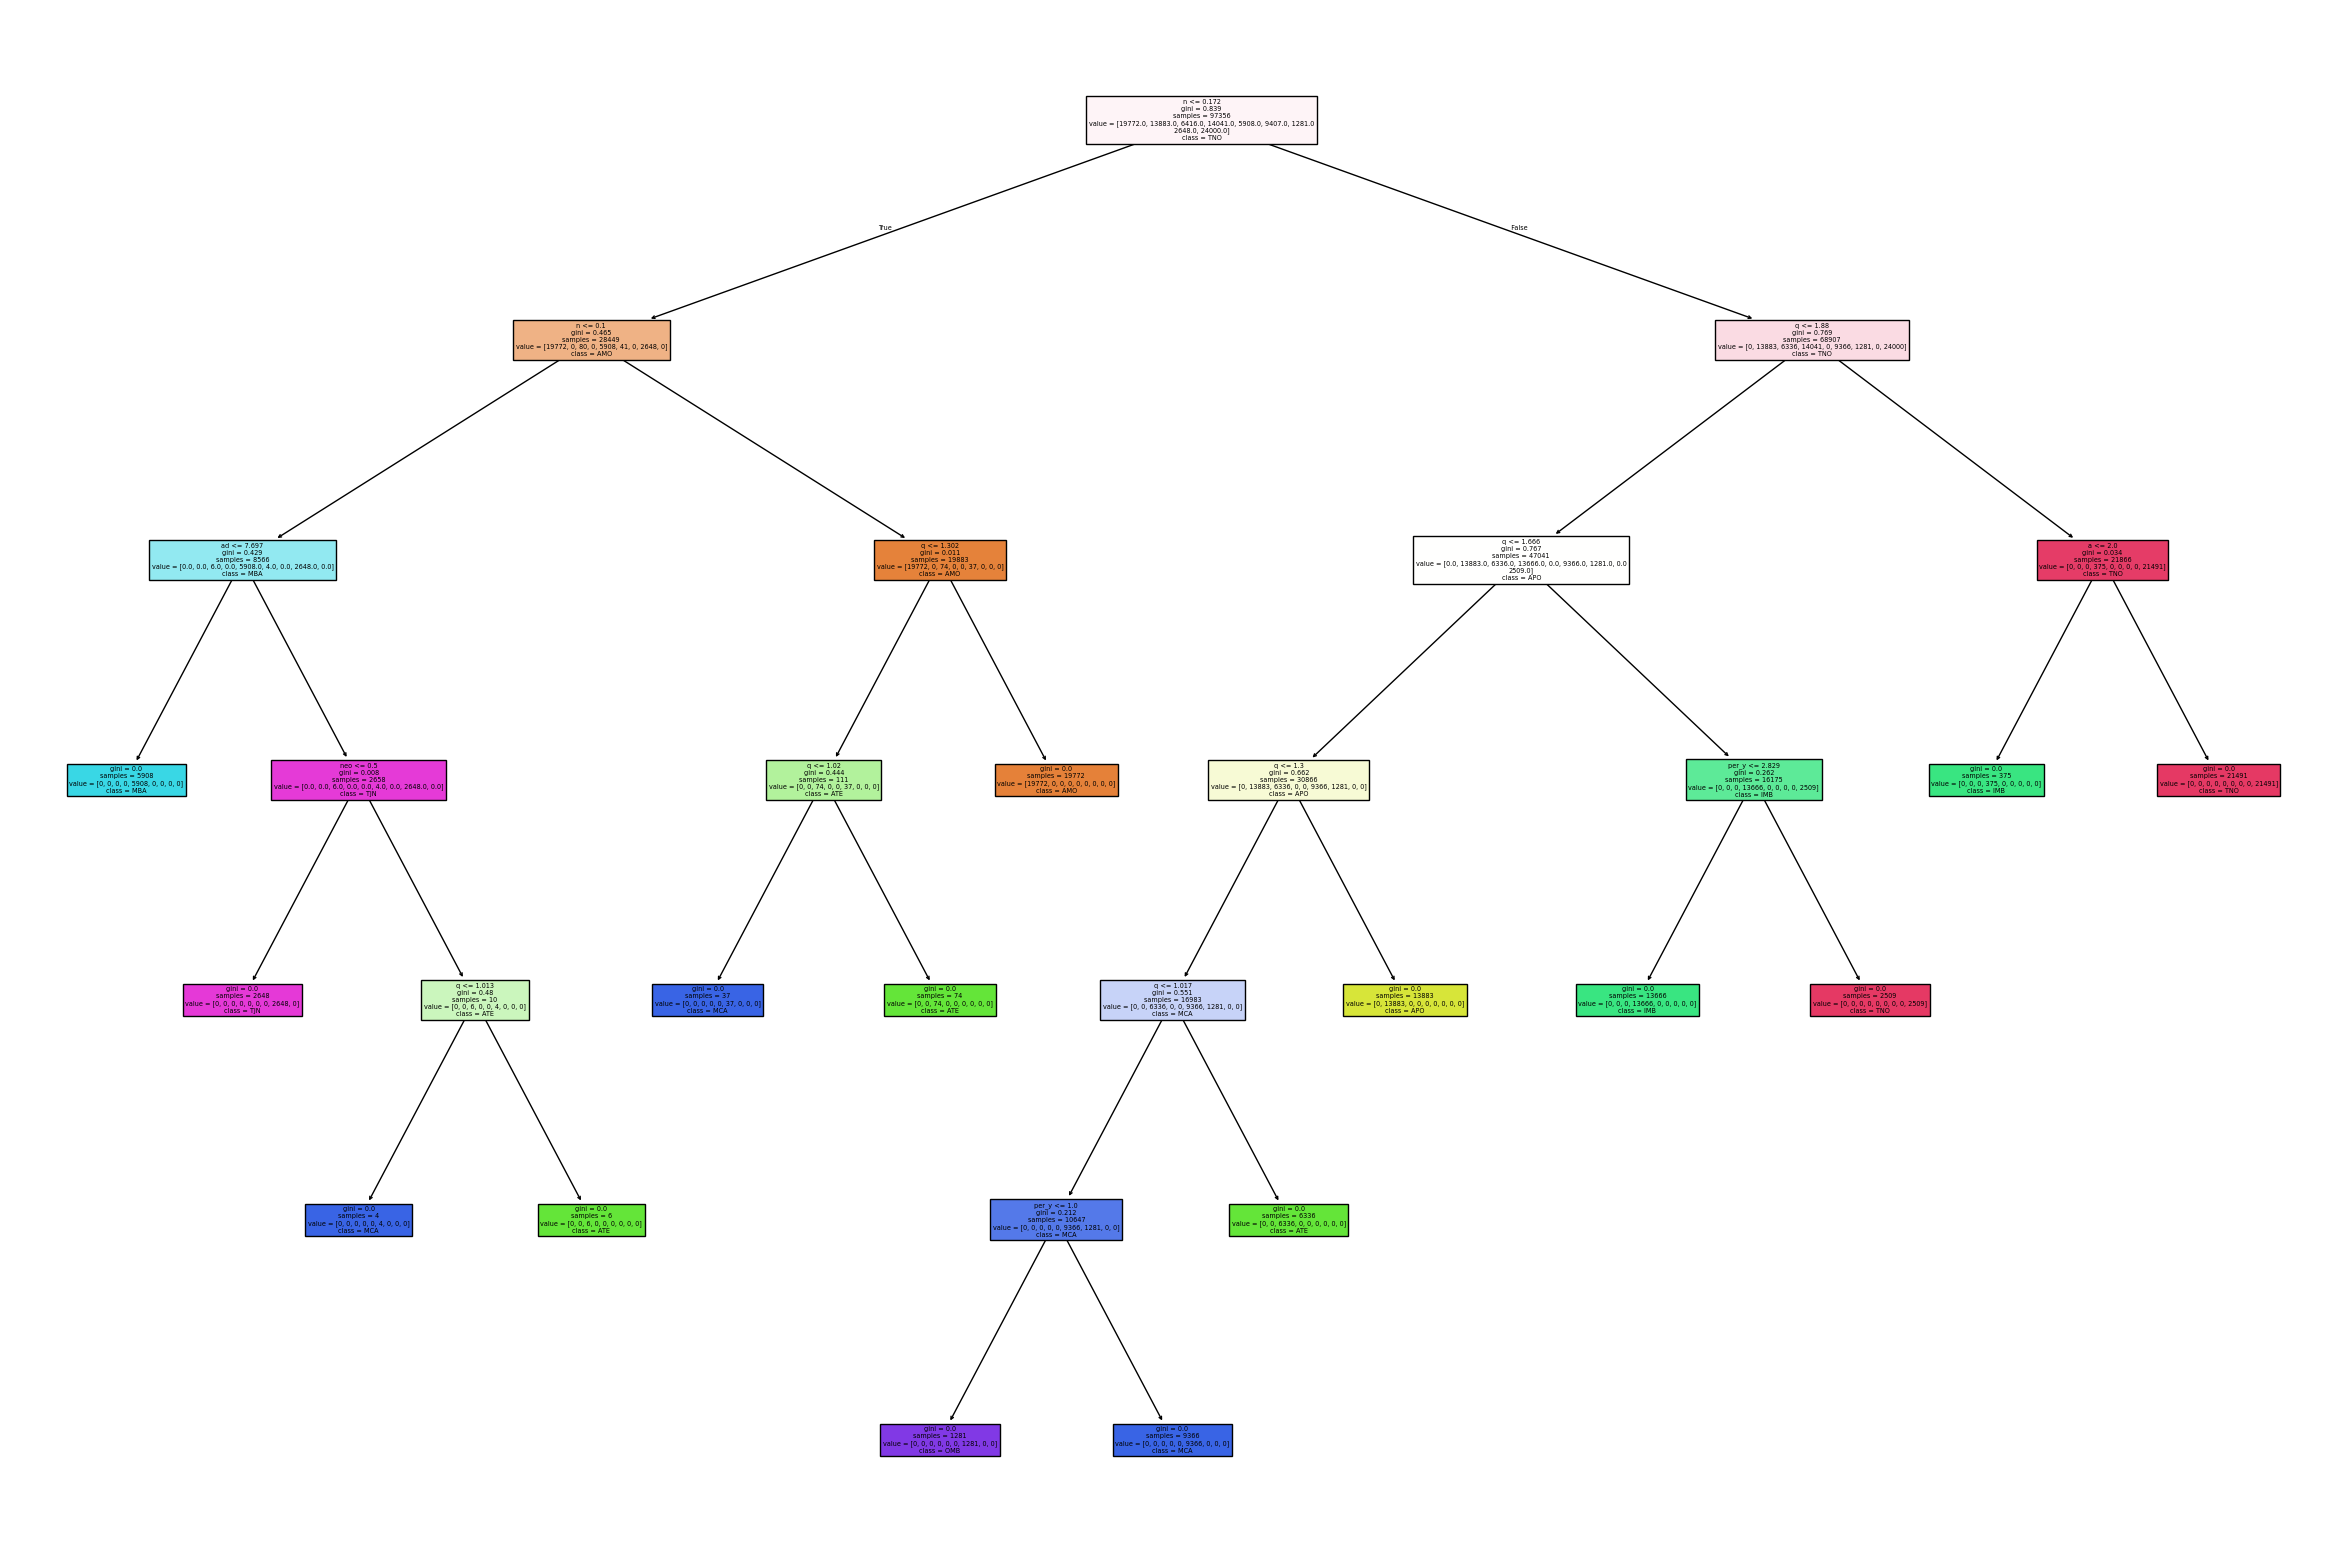

In [67]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree.fit(X_train, y_train)
# Визуализация дерева
fig, ax = plt.subplots(figsize=(30, 20))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=[str(c) for c in sorted(np.unique(y))],
    filled=True,
    ax=ax
)
plt.show()

Видим, что итоговое дерево достаточно глубокое (глубина = 6), однако идеально делит трейн по классам. Надо проверить метрики на тесте.

In [68]:
y_pred_tree = tree.predict(X_test)
y_pred_proba_tree = tree.predict_proba(X_test)

print(classification_report(y_test, y_pred_tree, target_names=target_names))
print("Accuracy:", accuracy_score(y_test, y_pred_tree))

              precision    recall  f1-score   support

         OMB       1.00      1.00      1.00      4943
         MCA       1.00      1.00      1.00      3471
         AMO       1.00      1.00      1.00      1604
         IMB       1.00      1.00      1.00      3511
         TJN       1.00      1.00      1.00      1477
         APO       1.00      1.00      1.00      2352
         ATE       1.00      1.00      1.00       320
         TNO       1.00      1.00      1.00       662
         MBA       1.00      1.00      1.00      6000

    accuracy                           1.00     24340
   macro avg       1.00      1.00      1.00     24340
weighted avg       1.00      1.00      1.00     24340

Accuracy: 0.9999589153656533


Видим, что на тесте у нас почти 100% точность, что говорит о том, что скорее всего классы изначально составлялись с оглядкой на данные.

### Применим стрижку деревьев

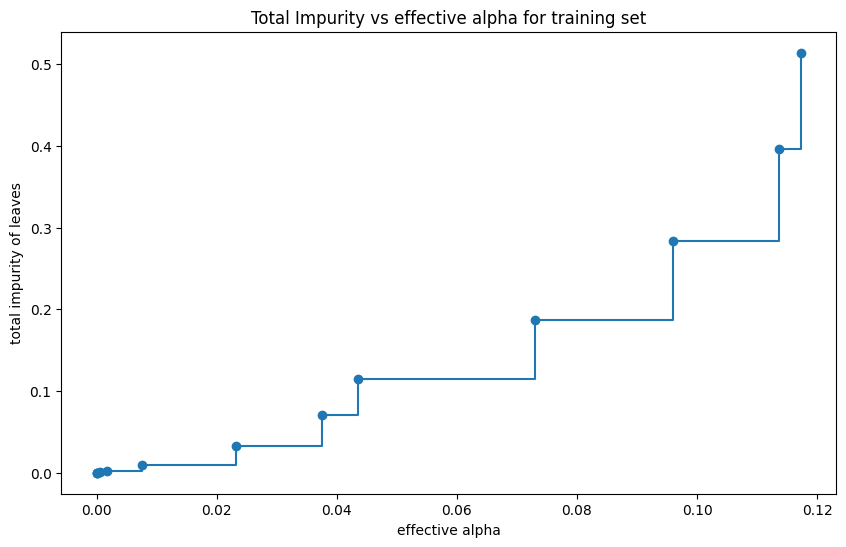

In [28]:
tmp_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
path = tmp_tree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [29]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1622008414335035


### Количество узлов и глубина дерева при стрижке

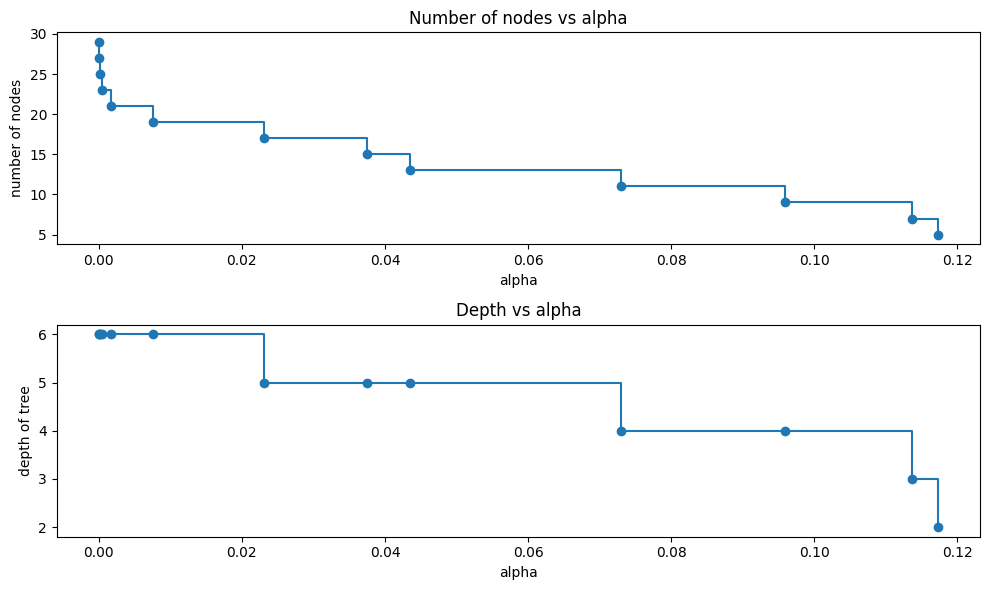

In [31]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Точность при стрижке

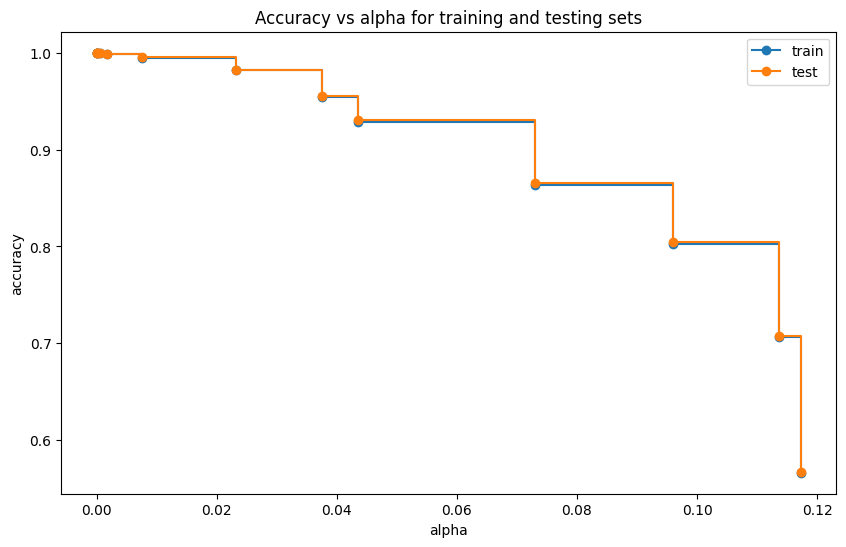

In [32]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

### Проведём кросс-валидацию для нахождения лучших параметров

In [ ]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

# Решающее дерево с cost-complexity pruning + кросс-валидация
tree_param_grid = {
    "ccp_alpha": ccp_alphas,
    "max_depth": [None, 3, 5, 7, 9],
    "min_samples_leaf": [1, 2, 5, 10]
}

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_grid = GridSearchCV(
    estimator=tree,
    param_grid=tree_param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)
tree_grid.fit(X_train, y_train)
best_tree = tree_grid.best_estimator_

In [34]:
# Лучшие параметры
tree_grid.best_params_

{'ccp_alpha': np.float64(0.0), 'max_depth': None, 'min_samples_leaf': 1}

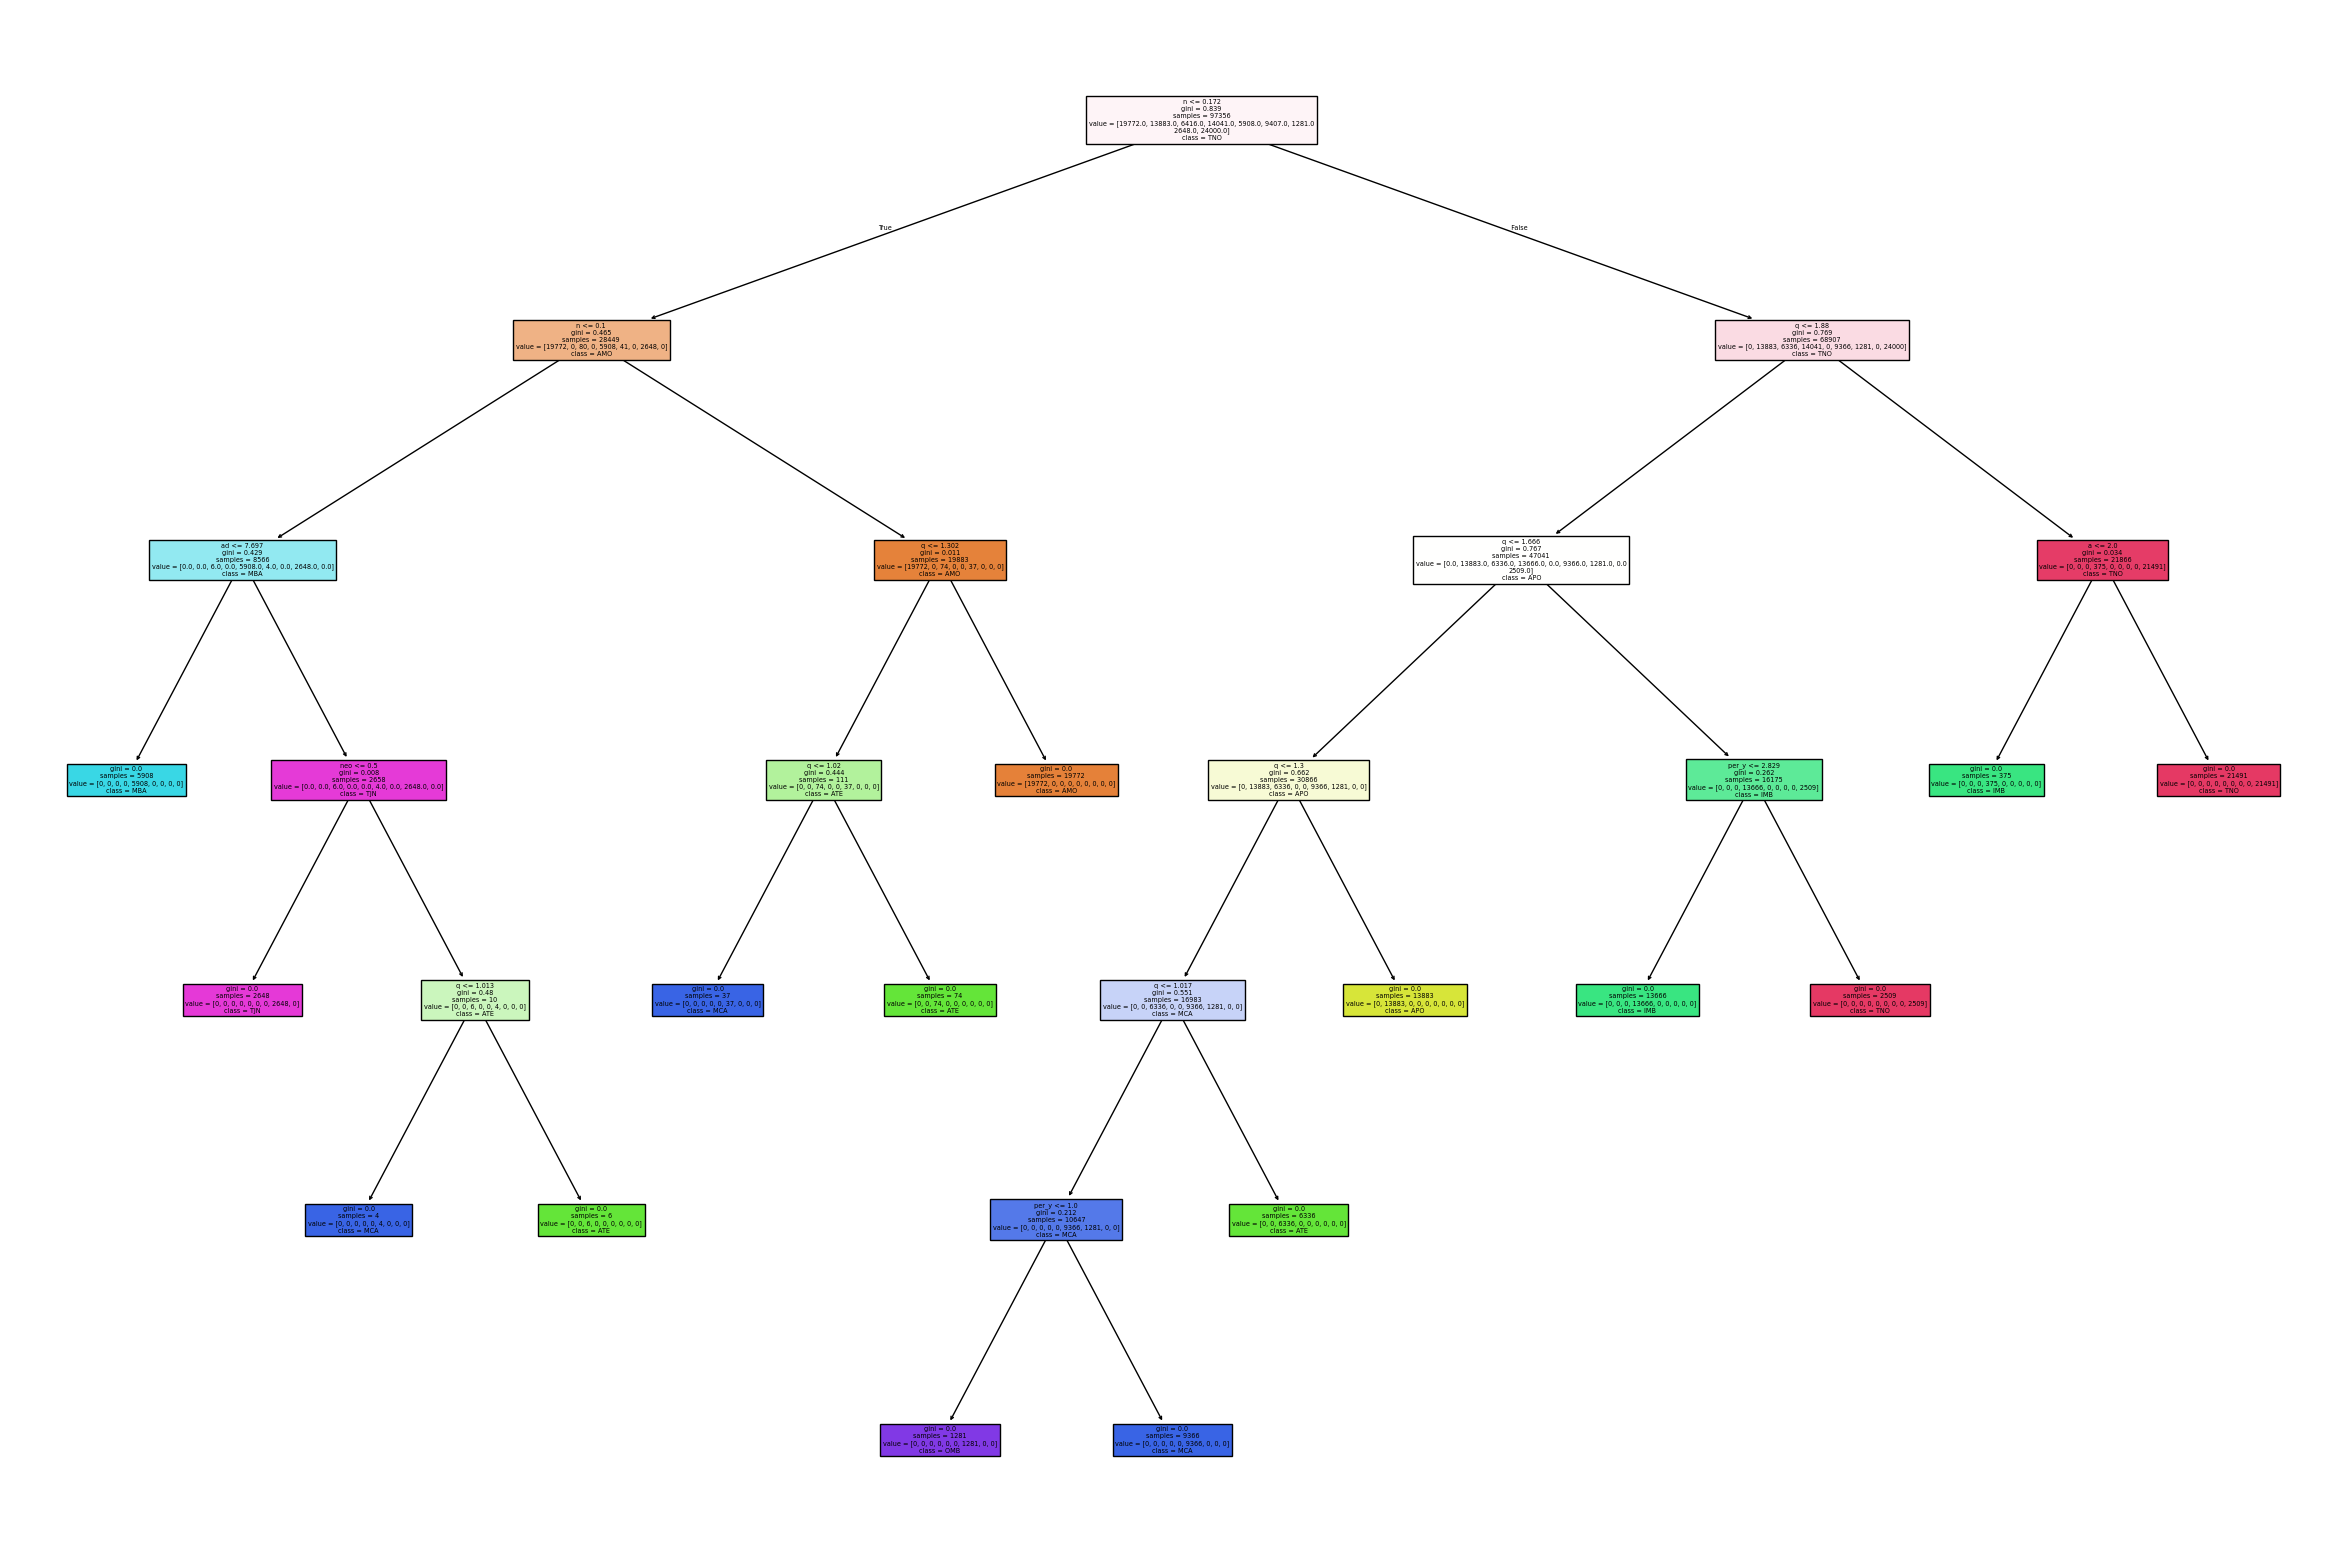

In [30]:
# Визуализация дерева
fig, ax = plt.subplots(figsize=(30, 20))
plot_tree(
    best_tree,
    feature_names=X.columns,
    class_names=[str(c) for c in sorted(np.unique(y))],
    filled=True,
    ax=ax
)
plt.show()

Видим, что стрижка не нужна и мы получаем то же самое дерево.

### Как выглядит разделяющая гиперплоскость для двух самых важных признаков

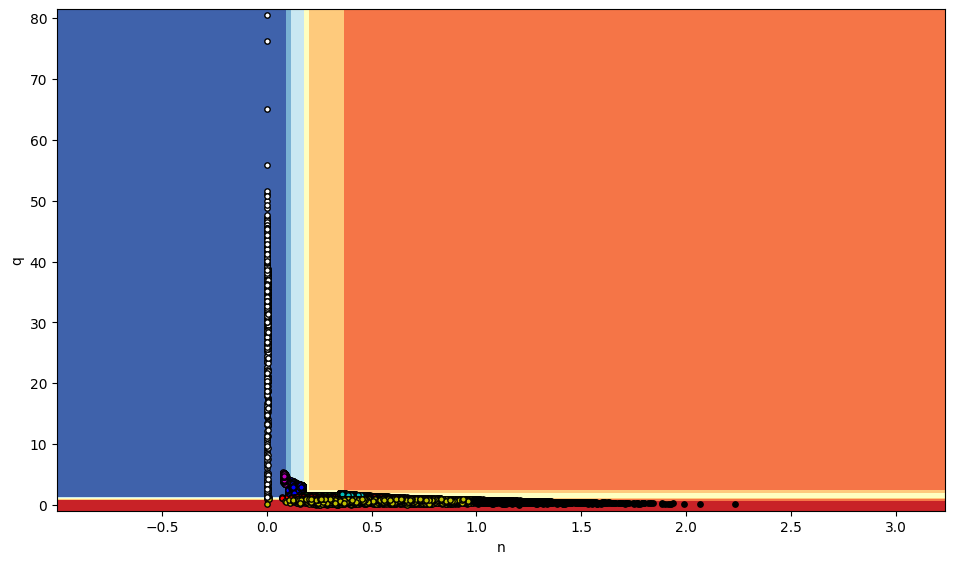

In [35]:
# Рисуем разделяющие гиперплоскости
fig, ax = plt.subplots(figsize=(10, 6))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
clf = DecisionTreeClassifier(**tree_grid.best_params_).fit(X[["n", "q"]], y)
DecisionBoundaryDisplay.from_estimator(
    clf,
    X[["n", "q"]],
    cmap=plt.cm.RdYlBu,
    response_method="predict",
    ax=ax,
    xlabel="n",
    ylabel="q",
)

# Добавляем точки
for i, color in zip(range(8), "bgrcmykw"):
    idx = np.asarray(y_int == i).nonzero()
    plt.scatter(
        X["n"].iloc[idx],
        X["q"].iloc[idx],
        c=color,
        label=[0, 1, 2],
        edgecolor="black",
        s=15,
    )

## Случайный лес

In [45]:
rf = RandomForestClassifier(
    n_estimators=20,
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
rf.fit(X_train, y_train)
print(f"CV accuracy: {np.mean(rf_cv_scores)} +- {2 * np.var(rf_cv_scores) / np.sqrt(cv.n_splits)}")

CV accuracy: 0.9998972852489072 +- 5.338580172815208e-09


In [46]:
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf, target_names=target_names))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

              precision    recall  f1-score   support

         OMB       1.00      1.00      1.00      4943
         MCA       1.00      1.00      1.00      3471
         AMO       1.00      1.00      1.00      1604
         IMB       1.00      1.00      1.00      3511
         TJN       1.00      1.00      1.00      1477
         APO       1.00      1.00      1.00      2352
         ATE       1.00      1.00      1.00       320
         TNO       1.00      1.00      1.00       662
         MBA       1.00      1.00      1.00      6000

    accuracy                           1.00     24340
   macro avg       1.00      1.00      1.00     24340
weighted avg       1.00      1.00      1.00     24340

Accuracy: 0.9999589153656533


Так как простое дерево уже дало 100% точность, то случайный лес, конечно, дал тот же результат.

### Ограничение на глубину

Давайте ограничим глубину дерева 3-мя и посмотрим на результат дерева и случайного леса:

In [69]:
tree_4 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=4)
tree_4.fit(X_train, y_train)

tree_4_cv_scores = cross_val_score(tree_4, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)

print(f"CV accuracy: {np.mean(tree_4_cv_scores)} +- {2 * np.var(tree_4_cv_scores) / np.sqrt(cv.n_splits)}")

y_pred_tree_4 = tree_4.predict(X_test)

print(classification_report(y_test, y_pred_tree_4, target_names=target_names, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_tree_4))

CV accuracy: 0.9216689329685306 +- 6.900456640979654e-08
              precision    recall  f1-score   support

         OMB       1.00      1.00      1.00      4943
         MCA       1.00      1.00      1.00      3471
         AMO       1.00      0.01      0.02      1604
         IMB       1.00      1.00      1.00      3511
         TJN       1.00      1.00      1.00      1477
         APO       0.55      1.00      0.71      2352
         ATE       0.00      0.00      0.00       320
         TNO       1.00      1.00      1.00       662
         MBA       1.00      1.00      1.00      6000

    accuracy                           0.92     24340
   macro avg       0.84      0.78      0.75     24340
weighted avg       0.94      0.92      0.89     24340

Accuracy: 0.9216926869350863


Действительно точность упала, причём один класс полностью не идентифицируется. Посмотрим на случайный лес:

In [92]:
rf_4 = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_4_cv_scores = cross_val_score(rf_4, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"CV accuracy: {np.mean(rf_4_cv_scores)} +- {2 * np.var(rf_4_cv_scores) / np.sqrt(cv.n_splits)}")
rf_4.fit(X_train, y_train)

y_pred_rf_4 = rf_4.predict(X_test)
y_pred_proba_rf_4 = rf_4.predict_proba(X_test)

print(classification_report(y_test, y_pred_rf_4, target_names=target_names, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_rf_4))

CV accuracy: 0.961717817774981 +- 2.0327835140336e-06
              precision    recall  f1-score   support

         OMB       1.00      1.00      1.00      4943
         MCA       0.96      0.97      0.97      3471
         AMO       1.00      0.60      0.75      1604
         IMB       0.97      1.00      0.99      3511
         TJN       1.00      1.00      1.00      1477
         APO       0.80      1.00      0.89      2352
         ATE       1.00      0.97      0.98       320
         TNO       1.00      1.00      1.00       662
         MBA       1.00      0.99      0.99      6000

    accuracy                           0.97     24340
   macro avg       0.97      0.95      0.95     24340
weighted avg       0.97      0.97      0.96     24340

Accuracy: 0.9662695152013147


Стало получше, хотя два небольших класса остались не идентифицируемыми.

### Проведём для случайного леса поиск гиперпараметров

In [71]:
rf_4_param_grid = {
    "n_estimators": [10, 25, 50, 100, 200, 300],
    "max_depth": [1, 2, 3, 4],
    "min_samples_leaf": [1, 2, 5, 10]
}

rf_4 = RandomForestClassifier(random_state=RANDOM_STATE)
rf_4_grid = RandomizedSearchCV(
    estimator=rf_4,
    param_distributions=rf_4_param_grid,
    cv=cv,
    scoring="accuracy",
    random_state=RANDOM_STATE,
    n_iter=20,
    n_jobs=-1
)
rf_4_grid.fit(X_train, y_train)
rf_4_best: RandomForestClassifier = rf_4_grid.best_estimator_

In [72]:
rf_4_grid.best_params_

{'n_estimators': 300, 'min_samples_leaf': 1, 'max_depth': 4}

In [91]:
rf_4_best_cv_scores = cross_val_score(rf_4_best, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"CV accuracy: {np.mean(rf_4_best_cv_scores)} +- {2 * np.var(rf_4_best_cv_scores) / np.sqrt(cv.n_splits)}")
rf_4_best.fit(X_train, y_train)

y_pred_rf_4_best = rf_4_best.predict(X_test)
y_pred_proba_rf_4_best = rf_4_best.predict_proba(X_test)

print(classification_report(y_test, y_pred_rf_4_best, target_names=target_names, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_rf_4_best))

CV accuracy: 0.9799293437135868 +- 2.487664791230921e-06
              precision    recall  f1-score   support

         OMB       1.00      1.00      1.00      4943
         MCA       0.98      0.98      0.98      3471
         AMO       1.00      0.84      0.91      1604
         IMB       0.98      1.00      0.99      3511
         TJN       1.00      1.00      1.00      1477
         APO       0.91      1.00      0.95      2352
         ATE       1.00      1.00      1.00       320
         TNO       1.00      1.00      1.00       662
         MBA       1.00      0.99      1.00      6000

    accuracy                           0.98     24340
   macro avg       0.99      0.98      0.98     24340
weighted avg       0.99      0.98      0.98     24340

Accuracy: 0.9843878389482333


Видим, что точность немного возросла.

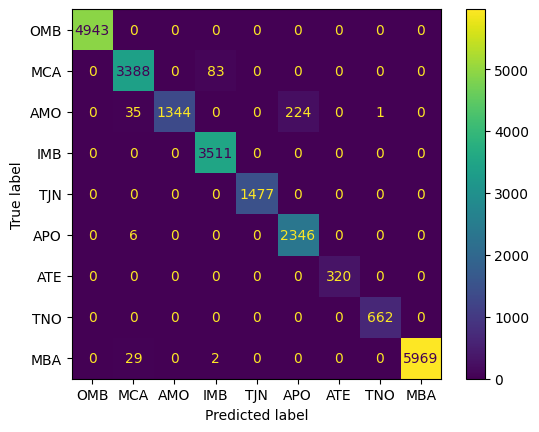

In [76]:
cm = confusion_matrix(y_test, y_pred_rf_4_best)
cm_display = ConfusionMatrixDisplay(cm, display_labels = target_names)
cm_display.plot()

plt.show()

### Зависимость точности от количества деревьев

In [83]:
n_estimators_list =[10, 25, 50, 100, 200, 300]

mean_scores   = []
std_scores    = []

for n in n_estimators_list:
    clf = RandomForestClassifier(
        n_estimators=n,
        max_depth=4,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

mean_scores = np.array(mean_scores)
std_scores  = np.array(std_scores)

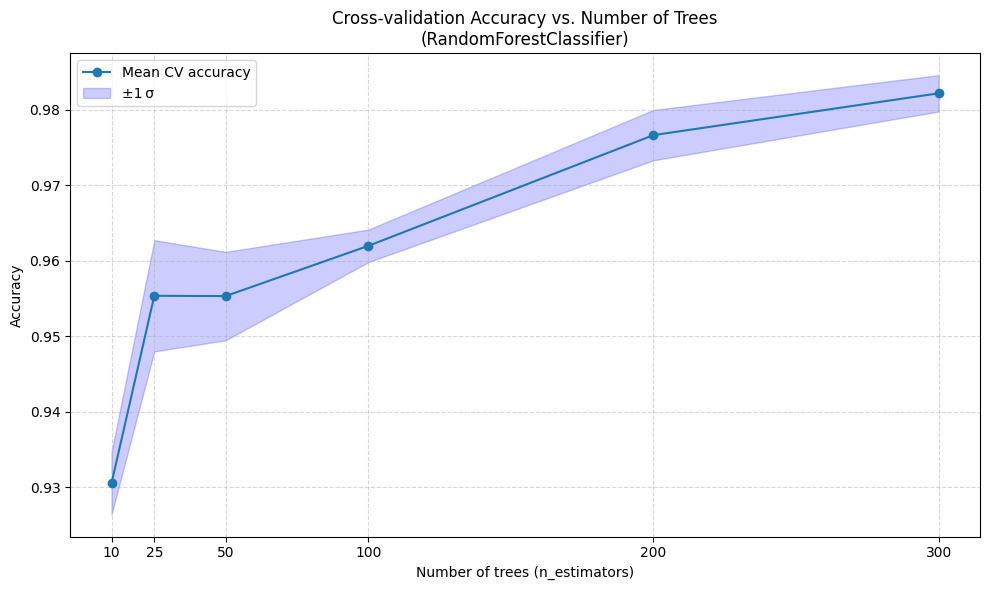

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, mean_scores, marker='o', label='Mean CV accuracy')
plt.fill_between(
    n_estimators_list,
    mean_scores - std_scores,
    mean_scores + std_scores,
    color='b',
    alpha=0.2,
    label='±1 σ'
)

plt.title('Cross‑validation Accuracy vs. Number of Trees\n(RandomForestClassifier)')
plt.xlabel('Number of trees (n_estimators)')
plt.ylabel('Accuracy')
plt.xticks(n_estimators_list)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Градиентный бустинг

(Мы используем гистограмный градиентный бустинг, так как обычный не умеет работать с NaN)

In [87]:
gb = HistGradientBoostingClassifier(
    max_iter=20,
    learning_rate=0.05,
    max_depth=2,
    random_state=RANDOM_STATE,
)
gb_cv_scores = cross_val_score(
    gb, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1
)
gb.fit(X_train, y_train)
print(f"CV accuracy: {np.mean(gb_cv_scores)} +- {2 * np.var(gb_cv_scores) / np.sqrt(cv.n_splits)}")

y_pred_gb = gb.predict(X_test)
y_pred_proba_gb = gb.predict_proba(X_test)

print(classification_report(y_test, y_pred_gb, target_names=target_names, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_gb))

CV accuracy: 0.9940527586211262 +- 2.728008067196103e-07
              precision    recall  f1-score   support

         OMB       0.99      1.00      0.99      4943
         MCA       1.00      0.99      0.99      3471
         AMO       1.00      1.00      1.00      1604
         IMB       0.99      1.00      0.99      3511
         TJN       1.00      0.99      1.00      1477
         APO       0.99      1.00      0.99      2352
         ATE       1.00      0.90      0.95       320
         TNO       1.00      1.00      1.00       662
         MBA       1.00      0.99      0.99      6000

    accuracy                           0.99     24340
   macro avg       1.00      0.99      0.99     24340
weighted avg       0.99      0.99      0.99     24340

Accuracy: 0.9943714050944946


Для бустинга мы получили самый высокий score, который максимально близок к $1$. Однако для приличия подберём гиперпараметры.

In [88]:
gb_param_grid = {
    "max_iter": [10, 25, 50, 100, 200, 300],
    "learning_rate": np.logspace(-3, 3, 10),
    "max_depth": [1, 2, 3, 4],
    "min_samples_leaf": [1, 2, 5, 10]
}

gb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
gb_grid = RandomizedSearchCV(
    estimator=gb,
    param_distributions=gb_param_grid,
    cv=cv,
    scoring="accuracy",
    random_state=RANDOM_STATE,
    n_iter=20,
    n_jobs=-1
)
gb_grid.fit(X_train, y_train)
gb_best: HistGradientBoostingClassifier = gb_grid.best_estimator_

/home/unicornred/.local/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [89]:
gb_grid.best_params_

{'min_samples_leaf': 5,
 'max_iter': 300,
 'max_depth': 2,
 'learning_rate': np.float64(0.1)}

In [93]:
gb_best_cv_scores = cross_val_score(gb_best, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"CV accuracy: {np.mean(gb_best_cv_scores)} +- {2 * np.var(gb_best_cv_scores) / np.sqrt(cv.n_splits)}")
gb_best.fit(X_train, y_train)

y_pred_gb_best = gb_best.predict(X_test)
y_pred_proba_gb_best = gb_best.predict_proba(X_test)

print(classification_report(y_test, y_pred_gb_best, target_names=target_names, zero_division=0))
print("Accuracy:", accuracy_score(y_test, y_pred_gb_best))

CV accuracy: 0.9964460514648875 +- 2.9512351319569674e-07
              precision    recall  f1-score   support

         OMB       1.00      1.00      1.00      4943
         MCA       1.00      0.99      1.00      3471
         AMO       1.00      1.00      1.00      1604
         IMB       0.99      1.00      1.00      3511
         TJN       1.00      1.00      1.00      1477
         APO       0.99      1.00      1.00      2352
         ATE       0.99      0.96      0.98       320
         TNO       1.00      1.00      1.00       662
         MBA       1.00      1.00      1.00      6000

    accuracy                           1.00     24340
   macro avg       1.00      0.99      1.00     24340
weighted avg       1.00      1.00      1.00     24340

Accuracy: 0.9966721446179129


Даже получили небольшое увеличение score.

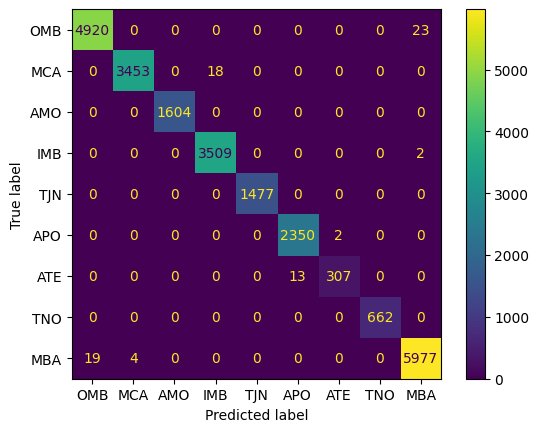

In [97]:
cm = confusion_matrix(y_test, y_pred_gb_best)
cm_display = ConfusionMatrixDisplay(cm, display_labels = target_names)
cm_display.plot()

plt.show()

### Зависимость точности от количества итераций в бустинге

In [95]:
max_iter_list =[10, 25, 50, 100, 200, 300]

mean_scores   = []
std_scores    = []

for n in n_estimators_list:
    clf = HistGradientBoostingClassifier(
        max_iter=n,
        max_depth=2,
        random_state=RANDOM_STATE
    )
    
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

mean_scores = np.array(mean_scores)
std_scores  = np.array(std_scores)

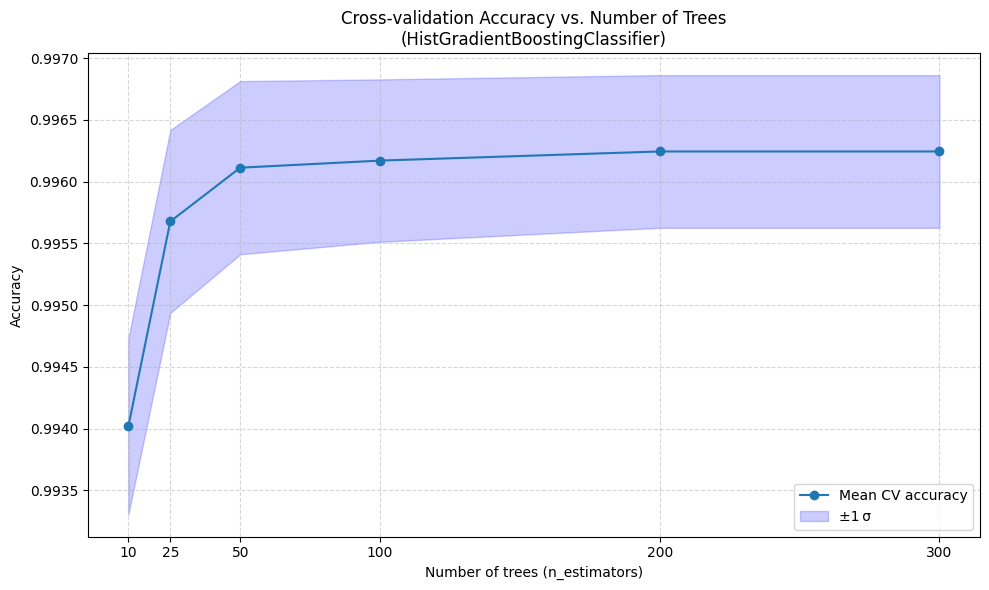

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, mean_scores, marker='o', label='Mean CV accuracy')
plt.fill_between(
    n_estimators_list,
    mean_scores - std_scores,
    mean_scores + std_scores,
    color='b',
    alpha=0.2,
    label='±1 σ'
)

plt.title('Cross‑validation Accuracy vs. Number of Trees\n(HistGradientBoostingClassifier)')
plt.xlabel('Number of trees (n_estimators)')
plt.ylabel('Accuracy')
plt.xticks(n_estimators_list)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()